<a href="https://colab.research.google.com/github/kvilleda12/Sales_forecasting_model/blob/main/pipeline_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import duckdb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

TRAIN_CSV_PATH = 'train.csv'
TEST_CSV_PATH = 'test.csv'
HOLIDAYS_CSV_PATH = 'holidays_events.csv'
OIL_CSV_PATH = 'oil.csv'
STORES_CSV_PATH = 'stores.csv'
TRANSACTIONS_CSV_PATH = 'transactions.csv'

CHUNK_SIZE = 500000
VALIDATION_MONTHS = 1
FORECAST_HORIZON = 15  # Number of days ahead we predict


In [7]:

def load_all_data(train_path, test_path, chunk_size):
    print("Step 1: Loading all data sources")
    start_time = time.time()


    holidays_df = pd.read_csv(HOLIDAYS_CSV_PATH, parse_dates=['date'])
    oil_df = pd.read_csv(OIL_CSV_PATH, parse_dates=['date'])
    stores_df = pd.read_csv(STORES_CSV_PATH)
    transactions_df = pd.read_csv(TRANSACTIONS_CSV_PATH, parse_dates=['date'])
    test_df = pd.read_csv(TEST_CSV_PATH, parse_dates=['date'])

    # Use chunking for train.csv file
    print(f"  Loading {train_path} in chunks of {chunk_size} rows...")
    train_chunk_iter = pd.read_csv(
        train_path,
        chunksize=chunk_size,
        dtype={
            'store_nbr': 'int16',
            'family': 'category',
            'sales': 'float32',
            'onpromotion': 'int32'
        },
        parse_dates=['date']
    )
    train_df = pd.concat([chunk for chunk in train_chunk_iter], ignore_index=True)
    print("  train.csv loaded successfully.")

    end_time = time.time()
    print(f"--- Data loaded in {end_time - start_time:.2f} seconds ---")
    print(f"Train DataFrame shape: {train_df.shape}")
    print(f"Memory usage: {train_df.memory_usage(deep=True).sum() / 1e9:.2f} GB\n")

    return train_df, test_df, holidays_df, oil_df, stores_df, transactions_df


In [8]:

def create_base_features(train_df, test_df, holidays_df, oil_df, stores_df, transactions_df, con):
    print("Step 2: Engineering features")
    start_time = time.time()

    con.register("train", train_df)
    con.register("test", test_df)
    con.register("holidays", holidays_df)
    con.register("oil", oil_df)
    con.register("stores", stores_df)
    con.register("transactions", transactions_df)

    H = FORECAST_HORIZON  # shorthand for SQL string

    feature_query = f"""
    PRAGMA threads=4;

    -- 1) Clean holidays
    WITH final_holiday AS (
        SELECT
            CAST(date AS DATE) AS date,
            CASE WHEN type = 'Transfer' THEN 'Holiday' ELSE type END AS type,
            locale,
            locale_name
        FROM holidays
        WHERE transferred = FALSE OR transferred IS NULL
    ),

    -- 2) Interpolate oil
    final_oil AS (
        WITH oil_date_to_date AS (
            SELECT CAST(date AS DATE) AS date, dcoilwtico
            FROM oil
        ),
        interp AS (
            SELECT
                date,
                LAG(dcoilwtico IGNORE NULLS) OVER (ORDER BY date) AS prev_price,
                LAG(date       IGNORE NULLS) OVER (ORDER BY date) AS prev_date,
                LEAD(dcoilwtico IGNORE NULLS) OVER (ORDER BY date) AS next_price,
                LEAD(date       IGNORE NULLS) OVER (ORDER BY date) AS next_date,
                dcoilwtico
            FROM oil_date_to_date
        )
        SELECT
            date,
            CASE
                WHEN dcoilwtico IS NOT NULL THEN dcoilwtico
                WHEN prev_price IS NULL OR next_price IS NULL THEN NULL
                ELSE prev_price +
                     ((epoch(date) - epoch(prev_date)) * (next_price - prev_price) / NULLIF(epoch(next_date) - epoch(prev_date),0))
            END AS oil_price
        FROM interp
    ),

    -- 3) Per-store holiday flags (with applicability)
    stores_holidays_cleaned AS (
        SELECT
            s.store_nbr,
            s.city,
            s.state,
            fh.date,
            fh.type,
            fh.locale,
            fh.locale_name,
            CASE WHEN fh.type = 'No Holiday' THEN 1 ELSE 0 END AS normal_day,
            CASE WHEN fh.type = 'Holiday'     THEN 1 ELSE 0 END AS holiday_day,
            CASE WHEN fh.type = 'Work Day'    THEN 1 ELSE 0 END AS work_day,
            CASE WHEN fh.type = 'Additional'  THEN 1 ELSE 0 END AS additional_day,
            CASE WHEN fh.type = 'Event'       THEN 1 ELSE 0 END AS event_day,
            CASE WHEN fh.type = 'Bridge'      THEN 1 ELSE 0 END AS bridge_day,
            CASE
                WHEN fh.type = 'No Holiday' THEN 0
                WHEN fh.locale = 'National' THEN 1
                WHEN fh.locale = 'Regional' AND (fh.locale_name = s.state OR fh.locale_name = s.city) THEN 1
                WHEN fh.locale = 'Local'    AND (fh.locale_name = s.city) THEN 1
                ELSE 0
            END AS special
        FROM stores s
        LEFT JOIN final_holiday fh ON TRUE
    ),

    -- 4) Scaffold (date x store x family)
    scaffold AS (
        WITH all_dates AS (
            SELECT CAST(d.day AS DATE) AS date
            FROM generate_series(
                (SELECT MIN(date) FROM train),
                (SELECT MAX(date) FROM test),
                INTERVAL 1 DAY
            ) AS d(day)
        ),
        all_stores_families AS (
            SELECT DISTINCT store_nbr, family FROM train
            UNION
            SELECT DISTINCT store_nbr, family FROM test
        )
        SELECT ad.date, asf.store_nbr, asf.family
        FROM all_dates ad
        CROSS JOIN all_stores_families asf
    ),

    -- 5) Join scaffold with stores, holidays, oil
    combined_features AS (
        SELECT
            s.date,
            s.store_nbr,
            s.family,
            st.type AS store_type,
            st.cluster,
            COALESCE(shc.normal_day, 1)  AS normal_day,
            COALESCE(shc.holiday_day, 0) AS holiday_day,
            COALESCE(shc.work_day, 0)    AS work_day,
            COALESCE(shc.additional_day,0) AS additional_day,
            COALESCE(shc.event_day, 0)   AS event_day,
            COALESCE(shc.bridge_day, 0)  AS bridge_day,
            COALESCE(shc.special, 0)     AS special,
            st.city,
            st.state,
            o.oil_price
        FROM scaffold s
        LEFT JOIN stores st ON s.store_nbr = st.store_nbr
        LEFT JOIN stores_holidays_cleaned shc ON s.store_nbr = shc.store_nbr AND s.date = shc.date
        LEFT JOIN final_oil o ON s.date = o.date
    ),

    -- 6) Attach observed train/test and transactions (for lags only)
    full_data AS (
        SELECT
            cf.*,
            tr.sales,
            tr.onpromotion,
            tx.transactions,
            COALESCE(te.id, tr.id) AS id,
            CASE WHEN tr.id IS NOT NULL THEN 1 ELSE 0 END AS is_train
        FROM combined_features cf
        LEFT JOIN train tr ON cf.date = tr.date AND cf.store_nbr = tr.store_nbr AND cf.family = tr.family
        LEFT JOIN test  te ON cf.date = te.date AND cf.store_nbr = te.store_nbr AND cf.family = te.family
        LEFT JOIN transactions tx ON cf.date = tx.date AND cf.store_nbr = tx.store_nbr
        WHERE cf.date >= '2013-01-01'
    ),

    -- 7) Calendar + lags/rolls. IMPORTANT: we DO NOT select raw transactions in the final output.
    features_with_lags AS (
        SELECT
            *,
            DAYOFWEEK(date)::TINYINT  AS day_of_week,
            DAYOFMONTH(date)::TINYINT AS day_of_month,
            WEEKOFYEAR(date)::SMALLINT AS week,
            MONTH(date)::TINYINT      AS month,
            YEAR(date)::SMALLINT      AS year,
            CASE WHEN DAYOFMONTH(date) = 15 OR date = LAST_DAY(date) THEN 1 ELSE 0 END AS is_payday,
            CASE WHEN date >= '2016-04-16' AND date <= '2016-06-10' THEN 1 ELSE 0 END AS is_earthquake_period,

            -- Immediate sales lags
            LAG(sales, 1,  -1) OVER (PARTITION BY store_nbr, family ORDER BY date) AS sales_lag_1,
            LAG(sales, 7,  -1) OVER (PARTITION BY store_nbr, family ORDER BY date) AS sales_lag_7,
            LAG(sales, 14, -1) OVER (PARTITION BY store_nbr, family ORDER BY date) AS sales_lag_14,
            LAG(sales, 28, -1) OVER (PARTITION BY store_nbr, family ORDER BY date) AS sales_lag_28,

            -- Rolling windows ending yesterday
            COALESCE(AVG(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 7  PRECEDING AND 1 PRECEDING), -1) AS avg_7,
            COALESCE(STDDEV_SAMP(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 7  PRECEDING AND 1 PRECEDING), -1) AS sales_rolling_std_7,
            COALESCE(MAX(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 7  PRECEDING AND 1 PRECEDING) -
                     MIN(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 7  PRECEDING AND 1 PRECEDING), -1) AS sales_rolling_range_7,

            COALESCE(AVG(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 14 PRECEDING AND 1 PRECEDING), -1) AS avg_14,
            COALESCE(STDDEV_SAMP(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 14 PRECEDING AND 1 PRECEDING), -1) AS sales_rolling_std_14,
            COALESCE(MAX(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 14 PRECEDING AND 1 PRECEDING) -
                     MIN(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 14 PRECEDING AND 1 PRECEDING), -1) AS sales_rolling_range_14,

            COALESCE(AVG(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 28 PRECEDING AND 1 PRECEDING), -1) AS avg_28,
            COALESCE(STDDEV_SAMP(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 28 PRECEDING AND 1 PRECEDING), -1) AS sales_rolling_std_28,
            COALESCE(MAX(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 28 PRECEDING AND 1 PRECEDING) -
                     MIN(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN 28 PRECEDING AND 1 PRECEDING), -1) AS sales_rolling_range_28,

            -- Horizon-aligned features
            LAG(sales, {H},   -1) OVER (PARTITION BY store_nbr, family ORDER BY date) AS sales_lag_{H},
            LAG(sales, {H}+7, -1) OVER (PARTITION BY store_nbr, family ORDER BY date) AS sales_lag_{H+7},
            LAG(sales, {H}+14,-1) OVER (PARTITION BY store_nbr, family ORDER BY date) AS sales_lag_{H+14},

            COALESCE(AVG(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+6  PRECEDING AND {H} PRECEDING), -1) AS avg_7_lag_{H},
            COALESCE(STDDEV_SAMP(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+6  PRECEDING AND {H} PRECEDING), -1) AS std_7_lag_{H},
            COALESCE(MAX(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+6  PRECEDING AND {H} PRECEDING) -
                     MIN(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+6  PRECEDING AND {H} PRECEDING), -1) AS range_7_lag_{H},

            COALESCE(AVG(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+13 PRECEDING AND {H} PRECEDING), -1) AS avg_14_lag_{H},
            COALESCE(STDDEV_SAMP(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+13 PRECEDING AND {H} PRECEDING), -1) AS std_14_lag_{H},
            COALESCE(MAX(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+13 PRECEDING AND {H} PRECEDING) -
                     MIN(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+13 PRECEDING AND {H} PRECEDING), -1) AS range_14_lag_{H},

            COALESCE(AVG(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+27 PRECEDING AND {H} PRECEDING), -1) AS avg_28_lag_{H},
            COALESCE(STDDEV_SAMP(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+27 PRECEDING AND {H} PRECEDING), -1) AS std_28_lag_{H},
            COALESCE(MAX(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+27 PRECEDING AND {H} PRECEDING) -
                     MIN(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ROWS BETWEEN {H}+27 PRECEDING AND {H} PRECEDING), -1) AS range_28_lag_{H},

            -- Exogenous horizon lags
            LAG(transactions, {H}, -1) OVER (PARTITION BY store_nbr ORDER BY date) AS transactions_lag_{H},
            LAG(oil_price,   {H}, -1) OVER (ORDER BY date) AS oil_price_lag_{H}
        FROM full_data
    )
    SELECT
        -- keep everything EXCEPT raw transactions
        date, store_nbr, family, sales, onpromotion, store_type, cluster,
        normal_day, holiday_day, work_day, additional_day, event_day, bridge_day, special,
        city, state, oil_price,
        day_of_week, day_of_month, week, month, year, is_payday, is_earthquake_period,
        sales_lag_1, sales_lag_7, sales_lag_14, sales_lag_28,
        avg_7, sales_rolling_std_7, sales_rolling_range_7,
        avg_14, sales_rolling_std_14, sales_rolling_range_14,
        avg_28, sales_rolling_std_28, sales_rolling_range_28,
        sales_lag_{H}, sales_lag_{H+7}, sales_lag_{H+14},
        avg_7_lag_{H}, std_7_lag_{H}, range_7_lag_{H},
        avg_14_lag_{H}, std_14_lag_{H}, range_14_lag_{H},
        avg_28_lag_{H}, std_28_lag_{H}, range_28_lag_{H},
        transactions_lag_{H},
        oil_price_lag_{H},
        id, is_train
    FROM features_with_lags
    WHERE id IS NOT NULL
    ORDER BY date, store_nbr, family
    """

    final_df = con.execute(feature_query).df()

    end_time = time.time()
    print(f"--- Step 2 complete in {end_time - start_time:.2f} seconds ---\n")
    return final_df


In [4]:
# === Correlation Matrix Heatmap ===
# Uses only training rows (is_train==1) to avoid leakage.
# Plots both: full matrix and a Top-K subset most correlated with 'sales'.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the engineered dataframe exists
try:
    df = full_featured_df.copy()
except NameError:
    raise RuntimeError("Expected `full_featured_df` to exist. Run the feature engineering cells first.")

# Use only training rows
df = df[df['is_train'] == 1].copy()

# Encode categoricals to numeric codes for correlation
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes.astype('int16')

# Drop non-useful columns
drop_cols = ['date', 'id']  # keep 'sales' to rank feature correlations
cols = [c for c in df.columns if c not in drop_cols]
num_df = df[cols]

# Pearson correlation
corr = num_df.corr(method='pearson', numeric_only=True)

# ---- Full matrix (can be large) ----
plt.figure(figsize=(12, 10))
im = plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.title("Correlation Matrix (All numeric features)")
plt.colorbar(im)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
plt.yticks(range(len(corr.index)), corr.index, fontsize=7)
plt.tight_layout()
plt.show()

# ---- Focused matrix: Top-K by |corr with sales| ----
if 'sales' in corr.columns:
    target_corr = corr['sales'].abs().sort_values(ascending=False)
    top_k = 30  # tweak as you like
    top_cols = target_corr.index[:top_k]
    top_corr = corr.loc[top_cols, top_cols]

    plt.figure(figsize=(10, 8))
    im2 = plt.imshow(top_corr, interpolation='nearest', aspect='auto')
    plt.title(f"Correlation Heatmap – Top {top_k} by |corr with sales|")
    plt.colorbar(im2)
    plt.xticks(range(len(top_cols)), top_cols, rotation=90, fontsize=8)
    plt.yticks(range(len(top_cols)), top_cols, fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'sales' not found in correlation matrix; skipping Top-K plot.")


In [ ]:

def train_and_evaluate_model(df):
    print("Step 3: Training and evaluating XGBoost")
    start_time = time.time()

    train_df = df[df['is_train'] == 1].copy()

    y = train_df['sales']
    # Drop non-feature columns; raw transactions is not present by design
    X = train_df.drop(columns=['sales', 'date', 'is_train', 'id'])

    last_date = train_df['date'].max()
    cutoff_date = last_date - pd.DateOffset(months=VALIDATION_MONTHS)
    print(f"  Split cutoff for validation: {cutoff_date.date()}")

    X_train = X[train_df['date'] < cutoff_date]
    y_train = y[train_df['date'] < cutoff_date]
    X_val   = X[train_df['date'] >= cutoff_date]
    y_val   = y[train_df['date'] >= cutoff_date]

    if X_train.empty or X_val.empty:
        raise ValueError("Training or validation set is empty. Check your date ranges.")

    y_train_log = np.log1p(y_train)
    y_val_log   = np.log1p(y_val)

    model = xgb.XGBRegressor(
        n_estimators=3000,
        learning_rate=0.02,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        enable_categorical=True,
        n_jobs=-1,
        early_stopping_rounds=100,
        tree_method="hist"
    )
    model.fit(X_train, y_train_log, eval_set=[(X_val, y_val_log)], verbose=False)

    log_preds = model.predict(X_val)
    preds = np.expm1(log_preds)
    preds[preds < 0] = 0

    rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(preds)))
    print("\n--- VALIDATION ---")
    print(f"RMSLE: {rmsle:.4f}")

    fig, ax = plt.subplots(figsize=(10, 8))
    xgb.plot_importance(model, ax=ax, max_num_features=20, importance_type='gain')
    plt.title("XGBoost Feature Importance (Validation)")
    plt.tight_layout()
    plt.show()

    end_time = time.time()
    print(f"--- Step 3 complete in {end_time - start_time:.2f} seconds ---")

    best_iter = getattr(model, "best_iteration", None)
    if best_iter is None:
        best_iter = getattr(model, "best_iteration_", None)
    if best_iter is None:
        best_iter = int(getattr(model, "best_ntree_limit", model.n_estimators))
    return best_iter


In [ ]:

def train_final_model_and_predict(df, best_iteration):
    print("\nStep 4: Training final model and creating submission")
    start_time = time.time()

    train_df = df[df['is_train'] == 1].copy()
    test_df  = df[df['is_train'] == 0].copy()

    y_train_full = train_df['sales']
    X_train_full = train_df.drop(columns=['sales', 'date', 'is_train', 'id'])
    y_train_full_log = np.log1p(y_train_full)

    X_test = test_df.drop(columns=['sales', 'date', 'is_train', 'id'])

    print("\n--- Column Consistency Check ---")
    train_cols = set(X_train_full.columns)
    test_cols = set(X_test.columns)
    if train_cols == test_cols:
        print(f"✅ Columns are consistent between train and test ({len(train_cols)} columns).")
    else:
        print("❌ Column mismatch!")
        print("In train not test:", sorted(train_cols - test_cols))
        print("In test not train:", sorted(test_cols - train_cols))
    print("---------------------------------\n")

    print(f"  Training final model ({best_iteration} rounds) on {len(X_train_full)} rows...")
    final_model = xgb.XGBRegressor(
        n_estimators=best_iteration,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.7,
        enable_categorical=True,
        n_jobs=-1,
        tree_method="hist"
    )
    final_model.fit(X_train_full, y_train_full_log, verbose=False)

    print(f"  Predicting on {len(X_test)} test rows...")
    log_predictions = final_model.predict(X_test)
    final_predictions = np.expm1(log_predictions)
    final_predictions[final_predictions < 0] = 0

    submission_df = pd.DataFrame({'id': test_df['id'].astype(int), 'sales': final_predictions})
    submission_df.to_csv('submission.csv', index=False)
    print("  'submission.csv' created successfully.")
    print(submission_df.head())

    end_time = time.time()
    print(f"--- Step 4 complete in {end_time - start_time:.2f} seconds ---")


Step 1: Loading all data sources
  Loading train.csv in chunks of 500000 rows...
  train.csv loaded successfully.
--- Data loaded in 14.33 seconds ---
Train DataFrame shape: (3000888, 6)
Memory usage: 0.08 GB

Step 2: Engineering features for train and test


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

--- Step 2 complete in 44.65 seconds ---

Final cleaning & dtype tweaks...
  Converting 'family' -> category
  Converting 'store_type' -> category
  Converting 'city' -> category
  Converting 'state' -> category
Step 2.5: Adding Pandas-based features (EWMA/trend)


/tmp/ipython-input-440850751.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['store_nbr', 'family'])['sales']
/tmp/ipython-input-440850751.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['store_nbr', 'family'])['sales']


--- Step 2.5 complete in 2.30 seconds ---

Step 3: Training and evaluating XGBoost
  Split cutoff for validation: 2017-07-15

--- VALIDATION ---
RMSLE: 0.3738


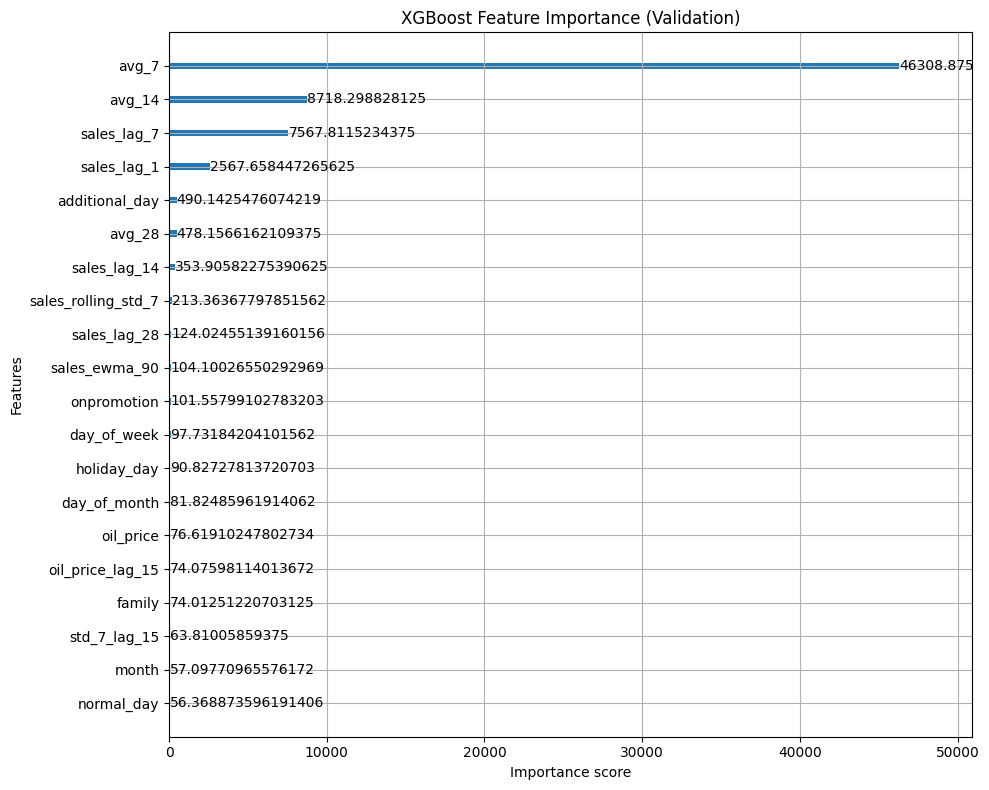

--- Step 3 complete in 2364.16 seconds ---

Step 4: Training final model and creating submission

--- Column Consistency Check ---
✅ Columns are consistent between train and test (52 columns).
---------------------------------

  Training final model (2999 rounds) on 3054348 rows...
  Predicting on 28512 test rows...
  'submission.csv' created successfully.
              id      sales
3054348  3000888  20.386204
3056130  3002670  11.279808
3057912  3004452  10.583430
3059694  3006234  10.696560
3061476  3008016  10.339493
--- Step 4 complete in 2197.01 seconds ---

✅ Pipeline Finished Successfully!


In [ ]:

if __name__ == '__main__':
    con = duckdb.connect(database=':memory:', read_only=False)

    # Step 1
    train_df, test_df, holidays_df, oil_df, stores_df, transactions_df = load_all_data(
        TRAIN_CSV_PATH, TEST_CSV_PATH, CHUNK_SIZE
    )

    # Step 2
    full_featured_df = create_base_features(
        train_df, test_df, holidays_df, oil_df, stores_df, transactions_df, con
    )

    # Final cleaning and dtypes (no raw transactions present)
    print("Final cleaning & dtype tweaks...")
    full_featured_df['oil_price'] = full_featured_df['oil_price'].fillna(-1).astype('float32')

    for col in full_featured_df.select_dtypes(include=['object']).columns:
        print(f"  Converting '{col}' -> category")
        full_featured_df[col] = full_featured_df[col].astype('category')

    # Step 2.5
    full_featured_df = add_pandas_features(full_featured_df)

    # Step 3
    best_iteration = train_and_evaluate_model(full_featured_df)

    # Step 4
    train_final_model_and_predict(full_featured_df, best_iteration)

    print("\n✅ Pipeline Finished Successfully!")
